<IPython.core.display.Javascript object>

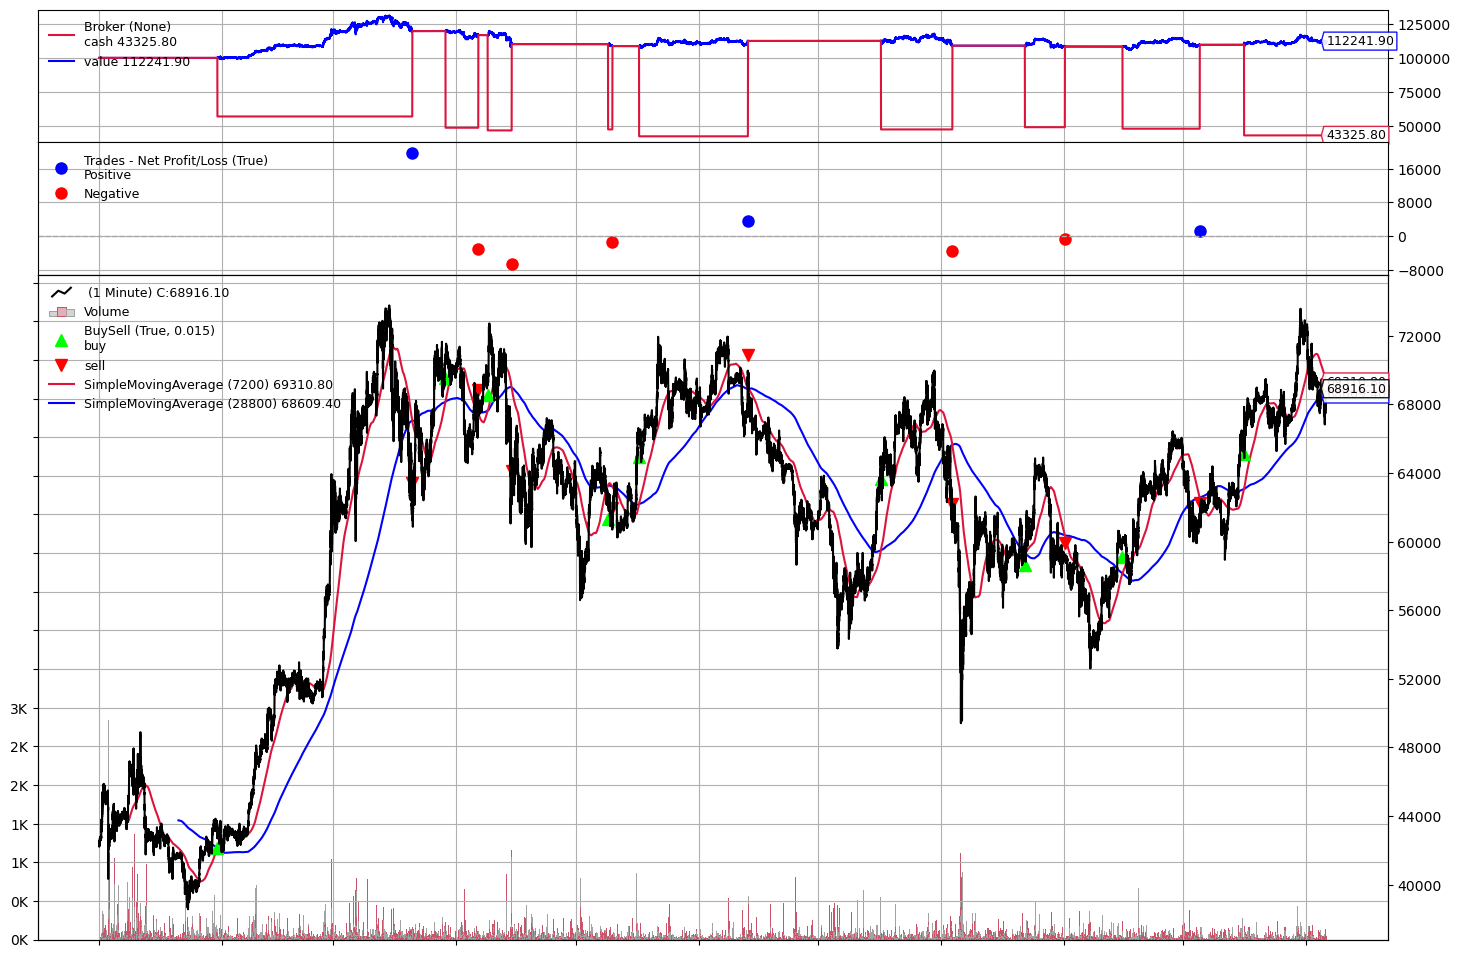

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import backtrader as bt
import pandas as pd
from datetime import datetime

plt.rcParams['figure.figsize'] = [15, 10]  # Set width and height in inches
# Load data
data = pd.read_csv('okx_BTCUSDT_1min_data.csv')
data['datetime'] = pd.to_datetime(data['Datetime'])
data.drop(columns=['Datetime', 'open_time'], inplace=True)
data.set_index('datetime', inplace=True)
#data = data.loc['20241101':]

# Use default PandasData class
bt_data = bt.feeds.PandasData(dataname=data, timeframe=bt.TimeFrame.Minutes)

# Define the SMA crossover strategy
class SmaCross(bt.Strategy):
    params = (('short_period', 5*24*60), ('long_period', 20*24*60))

    def __init__(self):
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.short_period)
        self.sma_long = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.long_period)

    def next(self):
        #print(f'Date: {self.datas[0].datetime.date(0)}, Close: {self.data.close[0]}')
        if self.sma_short[0] > self.sma_long[0] and not self.position:
            self.buy()
        elif self.sma_short[0] < self.sma_long[0] and self.position:
            self.sell() 

# Initialize Cerebro and add data/strategy
cerebro = bt.Cerebro()
cerebro.adddata(bt_data)
cerebro.addstrategy(SmaCross)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)

# Run the backtest and plot
cerebro.run()
cerebro.plot()[0][0]

In [57]:
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

Final Portfolio Value: 112241.89660000004


In [58]:
data

,open,high,low,close,volume
datetime,,,,,
2024-01-01 00:00:00,42398.1,42402.3,42392.0,42401.0,3.391989
2024-01-01 00:01:00,42400.1,42400.1,42339.8,42359.0,8.907504
2024-01-01 00:02:00,42359.1,42373.9,42350.6,42360.1,7.656267
2024-01-01 00:03:00,42360.1,42360.1,42320.4,42320.4,7.767605
2024-01-01 00:04:00,42322.0,42325.3,42316.2,42322.8,1.119983
...,...,...,...,...,...
2024-11-05 02:44:00,68903.0,68934.9,68903.0,68919.0,1.545942
2024-11-05 02:45:00,68919.9,68937.9,68900.0,68937.9,2.638381
2024-11-05 02:46:00,68937.9,68974.8,68908.0,68912.5,4.529232


In [59]:
import backtrader as bt

class MultiFactorStrategy(bt.Strategy):
    params = (
        ('sma_short_period', 10*24*60),
        ('sma_long_period', 30*24*60),
        ('rsi_period', 14*24*60),
        ('macd_me1', 12*24*60),
        ('macd_me2', 26*24*60),
        ('macd_signal', 9*24*60),
    )

    def __init__(self):
        # Calculate SMAs
        self.sma_short = bt.indicators.SMA(self.data.close, period=self.params.sma_short_period)
        self.sma_long = bt.indicators.SMA(self.data.close, period=self.params.sma_long_period)

        # Calculate RSI
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)

        # Calculate MACD
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.params.macd_me1,
            period_me2=self.params.macd_me2,
            period_signal=self.params.macd_signal
        )

        # Keep track of signals
        self.buy_signal = False
        self.sell_signal = False
    def next(self):
        # Reset signals
        self.buy_signal = False
        self.sell_signal = False

        # Factor 1: SMA Crossover Signal
        if self.sma_short[0] > self.sma_long[0]:
            sma_signal = 1  # Bullish
        else:
            sma_signal = -1  # Bearish

        # Factor 2: RSI Signal
        if self.rsi[0] < 30:
            rsi_signal = 1  # Oversold (Bullish)
        elif self.rsi[0] > 70:
            rsi_signal = -1  # Overbought (Bearish)
        else:
            rsi_signal = 0  # Neutral

        # Factor 3: MACD Signal
        if self.macd.macd[0] > self.macd.signal[0]:
            macd_signal = 1  # Bullish
        else:
            macd_signal = -1  # Bearish

        # Combine signals (simple majority voting)
        total_signal = sma_signal + rsi_signal + macd_signal

        # Generate buy/sell signals based on combined factors
        if total_signal >= 2:
            self.buy_signal = True
        elif total_signal <= -2:
            self.sell_signal = True

        # Execute trades
        if self.buy_signal and not self.position:
            self.buy()
            print(f'BUY at {self.data.datetime.date(0)} price {self.data.close[0]}')
        elif self.sell_signal and self.position:
            self.sell()
            print(f'SELL at {self.data.datetime.date(0)} price {self.data.close[0]}')

# Initialize Cerebro and add data/strategy
cerebro = bt.Cerebro()
cerebro.adddata(bt_data)  # Assuming bt_data is already prepared
cerebro.addstrategy(MultiFactorStrategy)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)

# Run the backtest and plot the results
cerebro.run()
cerebro.plot(style='candlestick')

BUY at 2024-02-05 price 42910.8
SELL at 2024-04-17 price 62991.6
BUY at 2024-05-18 price 66925.7
SELL at 2024-06-15 price 66130.6
BUY at 2024-07-19 price 64146.1
SELL at 2024-08-06 price 56740.5
BUY at 2024-08-26 price 63381.9
SELL at 2024-09-04 price 57888.0
BUY at 2024-09-19 price 62975.9
SELL at 2024-10-10 price 59758.0
BUY at 2024-10-15 price 65585.6


<IPython.core.display.Javascript object>

[[<Figure size 1500x1000 with 6 Axes>]]

<IPython.core.display.Javascript object>

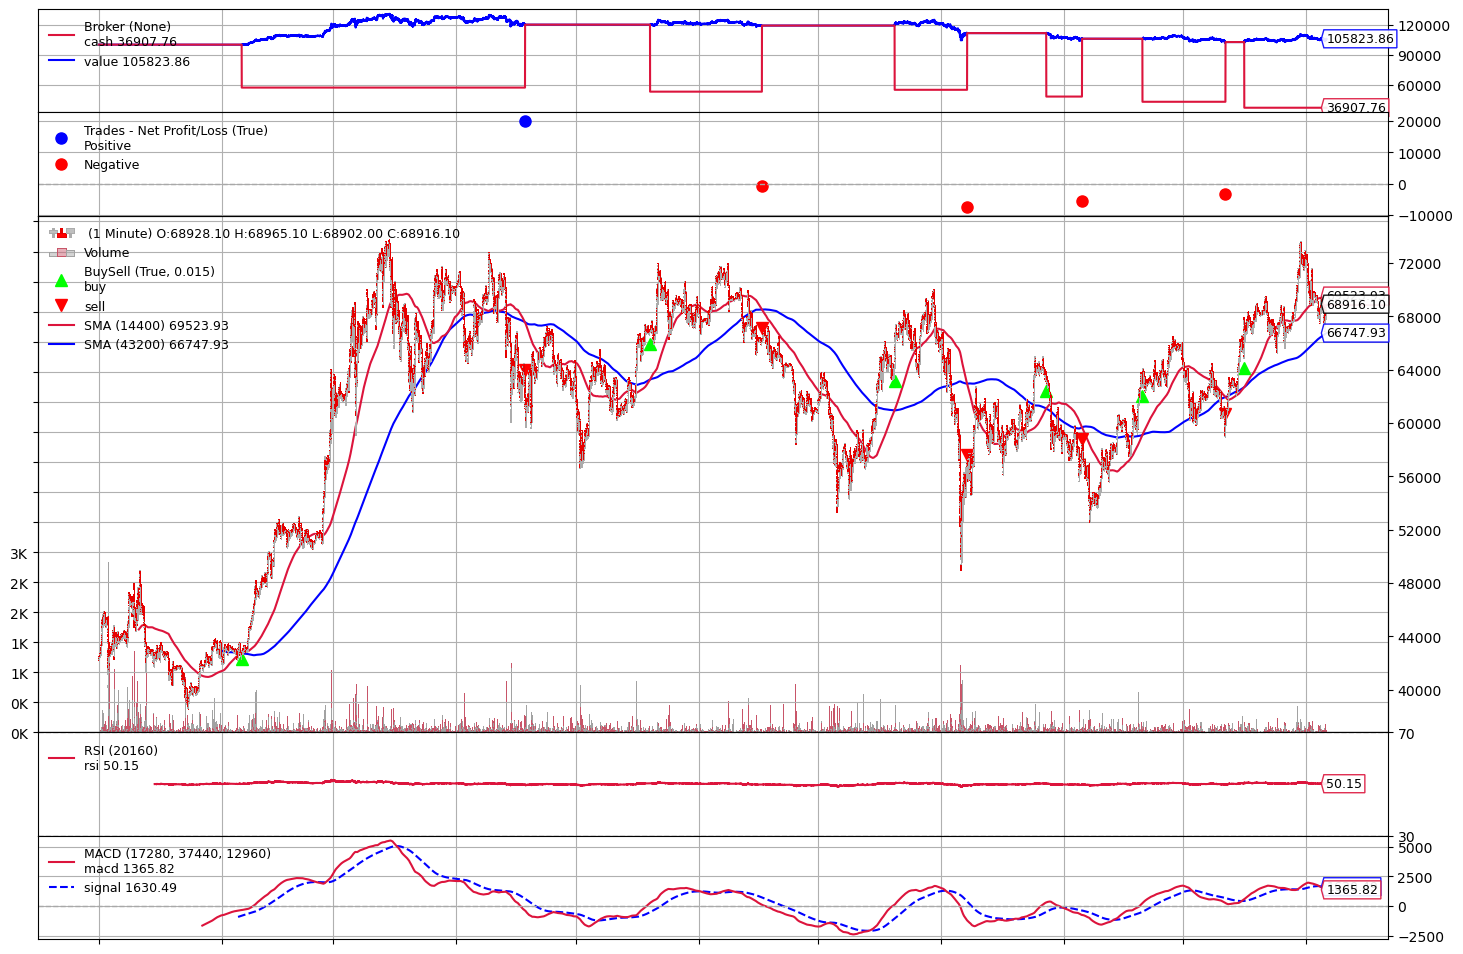

In [60]:
cerebro.plot(style='candlestick')[0][0]